## Overview ##

This is a starter notebook inspired by the 2017 [Logistic Regression on Tournament Seeds by Kasper P. Lauritzen](https://www.kaggle.com/kplauritzen/notebookde27b18258?scriptVersionId=804590) starter kernel. It creates a basic logistic regression model based on the seed differences between teams. 

Note that the predictions for Stage 1's sample submissions file are already based on known outcomes, and the Tourney data this model is trained on includes that data. For Stage 2, you will be predicting future outcomes based on the teams selected for the tournament on March 17.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


## Load the training data ##
We're keeping it simple & using only 2 files for this model: the Tourney seeds & Compact results.

In [2]:
data_dir = 'C:/Users/admin/Documents/JupyterNotebook/ICP/Project/mens-machine-learning-competition-2019/Stage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + '/NCAATourneyDetailedResults.csv')
df_reg_season = pd.read_csv(data_dir + "/RegularSeasonDetailedResults.csv")
df_teams = pd.read_csv(data_dir + "/Teams.csv")
df_tour_comp = pd.read_csv(data_dir + '/NCAATourneyCompactResults.csv')
df_team_conferences = pd.read_csv(data_dir + '/TeamConferences.csv')
df_conferences = pd.read_csv(data_dir + '/Conferences.csv')

In [3]:
print(dict.fromkeys(df_reg_season['Season']))

{2003: None, 2004: None, 2005: None, 2006: None, 2007: None, 2008: None, 2009: None, 2010: None, 2011: None, 2012: None, 2013: None, 2014: None, 2015: None, 2016: None, 2017: None, 2018: None, 2019: None}


In [4]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [6]:
df_reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [7]:
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2019
1,1102,Air Force,1985,2019
2,1103,Akron,1985,2019
3,1104,Alabama,1985,2019
4,1105,Alabama A&M,2000,2019


In [8]:
df_tour_comp.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [9]:
df_team_conferences.head()

,Season,TeamID,ConfAbbrev
0,1985,1114,a_sun
1,1985,1147,a_sun
2,1985,1204,a_sun
3,1985,1209,a_sun
4,1985,1215,a_sun


In [10]:
df_conferences.head()

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


In [11]:
def joinByID(df):
    df_teams_temp = df_teams.drop(['FirstD1Season', 'LastD1Season'], axis=1)
    df_new = pd.merge(df,df_teams_temp ,how='left', left_on = 'WTeamID', right_on = 'TeamID')
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"TeamName": "WinningTeamName"})
    df_new = pd.merge(df_new,df_teams_temp ,how='left', left_on = 'LTeamID', right_on = 'TeamID')
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"TeamName": "LosingTeamName"})
    df_conf = pd.merge(df_team_conferences,df_conferences,how='left',left_on = 'ConfAbbrev', right_on = 'ConfAbbrev')
    df_conf = df_conf.drop(['ConfAbbrev'], axis=1)
    df_new = pd.merge(df_new,df_conf,how = 'left',left_on = ['Season','WTeamID'], right_on = ['Season','TeamID'])
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"Description": "WinningTeamConference"}) 
    df_new = pd.merge(df_new,df_conf,how = 'left',left_on = ['Season','LTeamID'], right_on = ['Season','TeamID'])
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"Description": "LosingTeamConference"})
    return df_new
    


In [22]:
df_tour_joined = joinByID(df_tour)
df_reg_season_joined = joinByID(df_reg_season)
df_tour_comp_joined = joinByID(df_tour_comp)

In [24]:
df_final = df_tour_comp_joined.loc[df_tour_comp_joined.DayNum == 154]

In [114]:
winning = df_final.groupby('WinningTeamName').count()['WTeamID'].sort_values(ascending = False)
losing = df_final.groupby('LosingTeamName').count()['LTeamID'].sort_values(ascending = False)

In [115]:
X1 = winning.index.values
Y1 = winning
X2 = losing.index.values
Y2 = losing

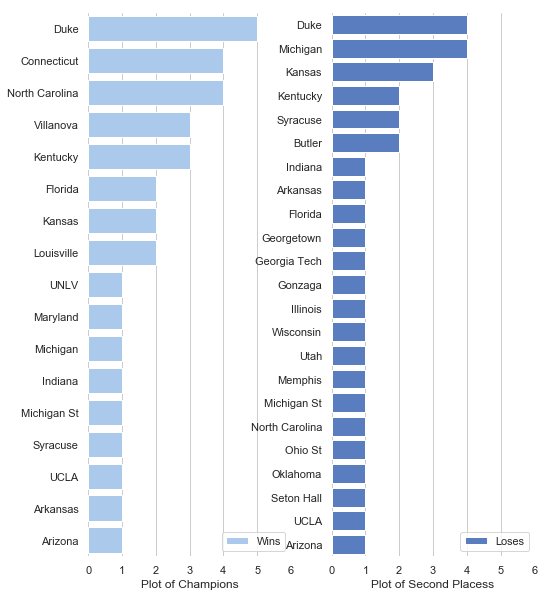

In [118]:
import seaborn as sns
sns.set(style="whitegrid")
f, ax = plt.subplots(1,2,figsize=(8, 10))
sns.set_color_codes("pastel")
sns.barplot(x=Y1, y=X1,
            label="Wins", color="b",ax = ax[0])
sns.set_color_codes("muted")
sns.barplot(x=Y2, y=X2,
            label="Loses", color="b",ax = ax[1])

# Add a legend and informative axis label
ax[0].legend(ncol=2, loc="lower right", frameon=True)
ax[0].set(xlim=(0, 6), ylabel="",
       xlabel="Plot of Champions")
ax[1].legend(ncol=2, loc="lower right", frameon=True)
ax[1].set(xlim=(0, 6), ylabel="",
       xlabel="Plot of Second Placess")
sns.despine(left=True, bottom=True)

In [23]:
print(df_tour_joined.columns)
print(df_reg_season_joined.columns)
print(df_tour_comp_joined.columns)

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WinningTeamName', 'LosingTeamName', 'WinningTeamConference',
       'LosingTeamConference'],
      dtype='object')
Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WinningTeamName', 'LosingTeamName', 'WinningTeamConference',
       'LosingTeamConference'],
      dtype='object')
Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WinningTeamName', 'LosingTeamName', 'W

In [124]:
data_reg_season = df_reg_season_joined[['WScore','LScore','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

In [128]:
corr = data_reg_season.corr()

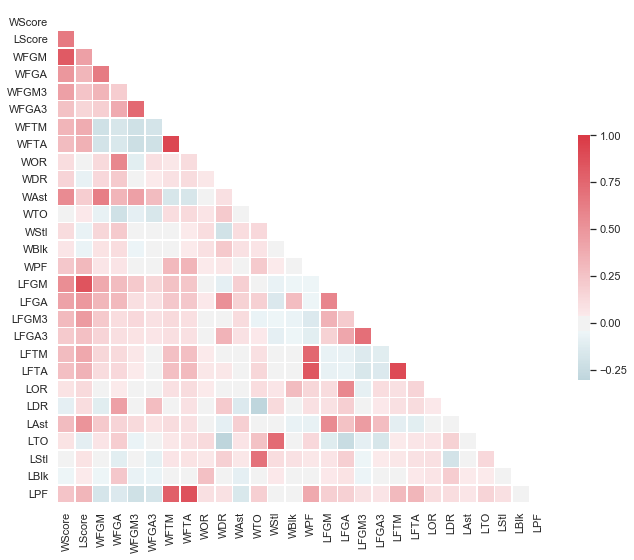

In [133]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [142]:
def getAverage():
    df_winning_teams = df_reg_season_joined[['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
            'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WinningTeamName']]
    df_losing_teams = df_reg_season_joined[['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
            'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LosingTeamName',]]
    columnDictWin = dict()
    columnDictLosing = dict()
    
    list1 = ['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
            'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WinningTeamName']
    list2 = ['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
            'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LosingTeamName',]
    list3 = ['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR',
            'Ast', 'TO', 'Stl', 'Blk', 'PF', 'TeamName',]
    for i in range(len(list1)):
        columnDictWin[list1[i]] = list3[i]
        columnDictLosing[list2[i]] = list3[i]
        
    df_losing_teams = df_losing_teams.rename(columns= columnDictLosing)
    df_winning_teams = df_winning_teams.rename(columns= columnDictWin)
    df = pd.concat([df_winning_teams,df_losing_teams], axis = 0)
    df = df.groupby('TeamName').mean()
    return df

In [143]:
df_average = getAverage()

In [144]:
df_average

,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
TeamName,,,,,,,,,,,,,
Abilene Chr,23.598726,53.828025,6.942675,19.012739,13.407643,18.929936,8.382166,21.961783,12.923567,13.535032,6.808917,2.363057,21.089172
Air Force,21.900000,48.726531,7.479592,20.851020,12.195918,17.475510,7.210204,21.110204,13.679592,12.126531,6.248980,2.046939,17.416327
Akron,24.828678,56.039106,7.925512,22.184358,13.983240,20.430168,11.102421,23.271881,13.869646,12.888268,6.588454,3.471136,18.929236
Alabama,24.458647,55.062030,6.133459,18.110902,14.593985,21.142857,11.578947,24.618421,12.142857,13.268797,6.644737,4.486842,17.622180
Alabama A&M,22.378788,56.279221,5.504329,18.162338,14.153680,21.636364,11.774892,23.090909,11.645022,15.376623,6.917749,3.558442,19.616883
Alabama St,22.778672,55.861167,5.873239,18.541247,13.490946,21.070423,12.603622,23.299799,11.374245,14.774648,6.418511,3.468813,19.543260
Albany NY,23.425331,53.758034,6.224953,17.603025,14.028355,19.126654,11.024575,23.824197,12.030246,13.491493,5.816635,2.368620,17.644612
Alcorn St,22.478702,55.845842,5.332657,17.036511,13.916836,21.099391,11.040568,22.645030,10.338742,16.397566,6.620690,3.050710,20.255578
American Univ,22.611538,51.065385,6.600000,18.363462,12.217308,17.555769,8.951923,23.107692,12.946154,13.307692,5.732692,2.723077,17.636538


In [165]:
### check if any of the two teams did not play
df_matchup = df_reg_season_joined[['WinningTeamName','LosingTeamName']]

In [166]:
df_matchup = df_matchup.rename(columns= {'WinningTeamName':'Team1','LosingTeamName':'Team2'})
df_matchup2 = df_matchup.rename(columns= {'WinningTeamName':'Team2','LosingTeamName':'Team1'})
print(df_matchup.shape,df_matchup2.shape)
df_match_data = pd.concat([df_matchup,df_matchup2], axis = 0)

(87504, 2) (87504, 2)


In [168]:
df_match_data = pd.merge(df_match_data,df_average,how = 'left',left_on = ['Team1'], right_on = ['TeamName'])
df_match_data = pd.merge(df_match_data,df_average,how = 'left',left_on = ['Team2'], right_on = ['TeamName'])
df_match_data = df_match_data.drop(['Team1','Team2'], axis=1)
df_match_data.head()

,FGM_x,FGA_x,FGM3_x,FGA3_x,FTM_x,FTA_x,OR_x,DR_x,Ast_x,TO_x,...,FGA3_y,FTM_y,FTA_y,OR_y,DR_y,Ast_y,TO_y,Stl_y,Blk_y,PF_y
0,24.458647,55.062030,6.133459,18.110902,14.593985,21.142857,11.578947,24.618421,12.142857,13.268797,...,19.366224,14.633776,20.396584,11.573055,24.952562,13.445920,12.907021,6.823529,3.916509,17.660342
1,26.381295,58.613309,6.627698,19.395683,15.791367,23.377698,12.850719,25.019784,14.967626,13.483813,...,18.604015,14.611314,21.534672,12.771898,24.863139,15.093066,13.047445,8.392336,5.830292,16.270073
2,25.857411,56.671670,7.138837,19.236398,15.759850,21.804878,11.418386,23.825516,15.118199,13.084428,...,22.090239,16.511971,22.163904,11.880295,24.528545,14.068140,12.845304,7.134438,3.690608,18.436464
3,23.191147,54.406439,5.778672,17.259557,14.144869,20.816901,11.778672,23.285714,11.629779,14.835010,...,20.254098,13.860656,20.250000,11.059426,24.247951,12.426230,13.305328,6.893443,3.778689,18.399590
4,26.010969,58.670932,6.513711,18.820841,15.297989,22.363803,13.144424,25.407678,12.990859,12.451554,...,17.537879,14.681818,21.259470,11.986742,24.801136,12.738636,14.079545,6.412879,4.295455,17.969697


In [169]:
matrixData = np.matrix(df_match_data)

In [170]:
y = np.concatenate((np.ones((87504,1)),np.zeros((87504,1))),axis = 0)

In [172]:

from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.regularizers import l2
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [175]:
x_train, x_test, y_train, y_test = train_test_split(matrixData,y.ravel(), test_size=0.10, random_state=0)

In [176]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((157507, 52), (157507,), (17501, 52), (17501,))

In [181]:
#defifne a sequentail Model
model = Sequential()

#Hidden Layer-1
model.add(Dense(100,activation='relu',input_dim=52))
model.add(Dropout(0.3, noise_shape=None, seed=None))

#Hidden Layer-2
model.add(Dense(100,activation = 'relu'))
model.add(Dropout(0.3, noise_shape=None, seed=None))

#Output layer
model.add(Dense(1,activation='sigmoid'))

In [182]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [183]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               5300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 15,501
Trainable params: 15,501
Non-trainable params: 0
_________________________________________________________________


In [184]:
model_output = model.fit(x_train,y_train,epochs=500,batch_size=20,verbose=1,validation_data=(x_test,y_test),)

Train on 157507 samples, validate on 17501 samples
Epoch 1/500
157507/157507 [==============================] - 9s 58us/step - loss: 0.7187 - acc: 0.4984 - val_loss: 0.6933 - val_acc: 0.4903
Epoch 2/500
157507/157507 [==============================] - 9s 56us/step - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6933 - val_acc: 0.4903
Epoch 3/500
157507/157507 [==============================] - 9s 58us/step - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6934 - val_acc: 0.4903
Epoch 4/500
157507/157507 [==============================] - 9s 56us/step - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 5/500
157507/157507 [==============================] - 9s 57us/step - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 6/500
157507/157507 [==============================] - 9s 56us/step - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 7/500
157507/157507 [==============================] - 9s 57us/step - loss: 0.6932 - acc: 0.5020 - val_

KeyboardInterrupt: 

In [1]:
df_reg_season_joined

NameError: name 'df_reg_season_joined' is not defined

$\text{Possessions} \ = \text{ 0.96 x (FGA + Turnovers + (0.475 x FTA) - Offensive Rebounds }$

$\text{Offensive Rating} \ = \text{ 100 x (Score / Possessions)}$

$\text{Defensive Rating} \ = \text{ 100 x (Opponent's Score / Possessions)}$

$\text{Strength of Schedule} \ = \text{ 100 x (Offensive Rating - Defensive Rating)}$

$\text{Performance Impact Estimator (PIE)} \ = \text{ Score + FGM + FTM - FGA - FTA + Defensive Rebounds + (0.5 * Offensive Rebounds) + Assists + Steals + (0.5 * Blocks) - PF - Turnovers}$

$\text{Team Impact Estimator (TIE)} \ = \text{ PIE / (PIE + Opponent's PIE) }$

$\text{Assist ratio} \ = \text{ 100 * Assists / (FGA + (0.475 * FTA) + Asistst + Turnovers))}$

$\text{Turnover ratio} \ = \text{ 100 * Turnovers / (FGA + (0.475 * FTA) + Assists + Turnovers)}$

$\text{True Shooting \%} \ = \text{ 100 * Team Points / (2 * (FGA + (0.475 * FTA)))}$

$\text{Effective FG\%} \ = \text{ (FGM + 0.5 * Threes Made) / FGA}$

$\text{Free Throw rate} \ = \text{ FTA / FGA}$

$\text{Offensive Rebound \%} \ = \text{ Offensive Rebounds / (Offensive Rebounds + Opponent's Defensive Rebounds)}$

$\text{Defensive Rebound \%} \ = \text{ Defensive Rebounds / (Defensive Rebounds + Opponent's Offensive Rebounds)}$

$\text{Total Rebound \%} \ = \text{ (Defensive Rebounds + Offensive Rebounds) / (Defensive Rebounds + Offensive Rebounds + Opponent's Defensive Rebounds + Opponent's Offensive Rebounds)}$

In [ ]:
df_reg_season_joined

def dimensionReducing(dataframe):
    

First, we'll simplify the datasets to remove the columns we won't be using and convert the seedings to the needed format (stripping the regional abbreviation in front of the seed).

In [14]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [15]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


## Merge seed for each team ##
Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.

In [16]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


Now we'll create a dataframe that summarizes wins & losses along with their corresponding seed differences. This is the meat of what we'll be creating our model on.

In [17]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [18]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the model ##
Use a basic logistic regression to train the model. You can set different C values to see how performance changes.

In [19]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default s

Best log_loss: -0.5547, with best C: 0.01


Text(0, 0.5, 'P(Team1 will win)')

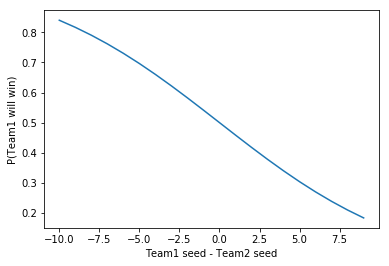

In [20]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

Plotting validates our intuition, that the probability a team will win decreases as the seed differential to its opponent decreases.

In [21]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

FileNotFoundError: [Errno 2] File b'C:/Users/admin/Documents/JupyterNotebook/ICP/Project/mens-machine-learning-competition-2019/DataFiles/SampleSubmissionStage1.csv' does not exist: b'C:/Users/admin/Documents/JupyterNotebook/ICP/Project/mens-machine-learning-competition-2019/DataFiles/SampleSubmissionStage1.csv'

In [22]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

NameError: name 'n_test_games' is not defined

## Make Predictions ##
Create predictions using the logistic regression model we trained.

In [23]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

NameError: name 'X_test' is not defined

Lastly, create your submission file!

In [ ]:
df_sample_sub.to_csv('logreg_seed_starter.csv', index=False)